In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

#### Funtion to retrieve from the folder having structure
data/
    train/
        class1/
            image1.png
            .
            .
        class2/
            .
            .
    test/
        .
    valid/
        .


In [2]:
def load_data(main_foler_path):
    images=[]
    labels=[]
    
    for data_type in os.listdir(main_foler_path):
        type_foler_path=os.path.join(main_foler_path,data_type)
        
        if not os.path.isdir(type_foler_path):
            continue
        for class_folder in os.listdir(type_foler_path):
            if class_folder.startswith('.'):
                continue
                
            class_folder_path=os.path.join(type_foler_path,class_folder)

            if not os.path.isdir(class_folder_path):
                continue

            for filename in tqdm(os.listdir(class_folder_path)):
                if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    image_path=os.path.join(class_folder_path,filename)
                    img=load_img(image_path,target_size=(224,224))
                    img=img_to_array(img)
                    label=class_folder

                    images.append(img)
                    labels.append(label)
    return np.array(images),np.array(labels)

#### Images folder

In [3]:
main_folder_path='data'

In [4]:
X,y=load_data(main_folder_path)

100%|████████████████████████████████████████| 148/148 [00:01<00:00, 137.05it/s]


## Image segmentaion and feature extraction using the K means clustering and pre defined model VGG16

#### Image segmentation

In [5]:
kmeans=KMeans(n_clusters=2,random_state=42)
X_flattened_images=X.reshape(X.shape[0],-1)
kmeans.fit(X_flattened_images)

/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [6]:
X_image_clusters=kmeans.predict(X_flattened_images)

#### Encoding labels to 0,1,2 and 3

In [7]:
from sklearn.preprocessing import OrdinalEncoder
encoder=OrdinalEncoder()
y_encoded=encoder.fit_transform(y.reshape(-1,1)).flatten()

#### Data splitting

In [8]:
X_train,X_test,y_train,y_test,X_cluster_train,X_cluster_test=train_test_split(X,y_encoded,
                                                                             X_image_clusters,
                                                                             test_size=0.3,
                                                                             random_state=42)

#### Loading VGG16 model for feature extraction

In [258]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
# Freeze VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

#### Preprocessing image before feature extraction

In [259]:
X_train_preprocessed=preprocess_input(X_train)
X_test_preprocessed=preprocess_input(X_test)

#### Extracting features

In [260]:
X_train_features=base_model.predict(X_train_preprocessed)
X_test_features=base_model.predict(X_test_preprocessed)

10/10 [==============================] - 73s 7s/step


#### Reshapping training and testing set

In [261]:
X_train_flatten=X_train_features.reshape(X_train_features.shape[0],-1)
X_test_flatten=X_test_features.reshape(X_test_features.shape[0],-1)

# Model building

### SVM model

In [247]:
from sklearn.svm import SVC
svm_clf_model=SVC(kernel='linear',C=1.0)
svm_clf_model.fit(np.concatenate([X_train_flatten,X_cluster_train.reshape(-1,1)],axis=1),
                 y_train)
y_pred_svm=svm_clf_model.predict(np.concatenate([X_test_flatten,X_cluster_test.reshape(-1,1)],axis=1))
accuracy_score_svm=accuracy_score(y_pred_svm,y_test)
print(f"Accuracy of SVM classifier : {accuracy_score_svm*100:.2f}%")

Accuracy of SVM classifier : 97.67%


### Logistic Regression model

In [1]:
from sklearn.linear_model import LogisticRegression
logr_clf_model=LogisticRegression(random_state=42)
logr_clf_model.fit(np.concatenate([X_train_flatten,X_cluster_train.reshape(-1,1)],axis=1),
                 y_train)
y_pred_logr=logr_clf_model.predict(np.concatenate([X_test_flatten,X_cluster_test.reshape(-1,1)],axis=1))
accuracy_score_logr=accuracy_score(y_pred_logr,y_test)
print(f"Accuracy of Logistic Regression classifier : {accuracy_score_logr*100:.2f}%")

python(2135) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


NameError: name 'np' is not defined

### SVM and Logistic regression performance measures

In [258]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming svm_clf and logr_clf are your trained SVM and Logistic Regression models
# y_test, y_pred_svm, and y_pred_logr are your test labels and predictions

# SVM
svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

# Logistic Regression
logr_precision = precision_score(y_test, y_pred_logr, average='weighted')
logr_recall = recall_score(y_test, y_pred_logr, average='weighted')
logr_f1 = f1_score(y_test, y_pred_logr, average='weighted')
print(f"Accuracy of SVM classifier : {accuracy_score_svm*100:.2f}%")
print(f"SVM Precision: {svm_precision*100:.2f}%")
print(f"SVM Recall: {svm_recall*100:.2f}%")
print(f"SVM F1 Score: {svm_f1*100:.2f}%")
print(f"Accuracy of Logistic Regression classifier : {accuracy_score_logr*100:.2f}%")
print(f"Logistic Regression Precision: {logr_precision*100:.2f}%")
print(f"Logistic Regression Recall: {logr_recall*100:.2f}%")
print(f"Logistic Regression F1 Score: {logr_f1*100:.2f}%")

Accuracy of SVM classifier : 97.67%
SVM Precision: 97.69%
SVM Recall: 97.67%
SVM F1 Score: 97.67%
Accuracy of Logistic Regression classifier : 96.67%
Logistic Regression Precision: 96.70%
Logistic Regression Recall: 96.67%
Logistic Regression F1 Score: 96.67%


## Other different models

### XGBoost model

In [200]:
from xgboost import XGBClassifier
xgb_clf_model=XGBClassifier()
xgb_clf_model.fit(np.concatenate([X_train_flatten,X_cluster_train.reshape(-1,1)],axis=1),
                 y_train)
y_pred_xgb=xgb_clf_model.predict(np.concatenate([X_test_flatten,X_cluster_test.reshape(-1,1)],axis=1))
accuracy_score_xgb=accuracy_score(y_pred_xgb,y_test)
print(f"Accuracy of XGBoost classifier : {accuracy_score_xgb*100:.2f}%")

Accuracy of XGBoost classifier : 92.67%


### Decision Tree model

In [207]:
from sklearn.tree import DecisionTreeClassifier
dt_clf_model=DecisionTreeClassifier(max_depth=10)
dt_clf_model.fit(np.concatenate([X_train_flatten,X_cluster_train.reshape(-1,1)],axis=1),y_train)
y_pred_dt=dt_clf_model.predict(np.concatenate([X_test_flatten,X_cluster_test.reshape(-1,1)],axis=1))
accuracy_score_dt=accuracy_score(y_pred_dt,y_test)
print(f"Accuracy of Decision Tree classifier : {accuracy_score_dt*100:.2f}%")

Accuracy of Decision Tree classifier : 72.33%


### Random Forest model

In [209]:
from sklearn.ensemble import RandomForestClassifier
rf_clf_model=RandomForestClassifier(max_depth=100)
rf_clf_model.fit(np.concatenate([X_train_flatten,X_cluster_train.reshape(-1,1)],axis=1),y_train)
y_pred_rf=rf_clf_model.predict(np.concatenate([X_test_flatten,X_cluster_test.reshape(-1,1)],axis=1))
accuracy_score_rf=accuracy_score(y_pred_rf,y_test)
print(f"Accuracy of Random Forest classifier : {accuracy_score_rf*100:.2f}%")

Accuracy of Random Forest classifier : 91.00%


### Ensemble model with voting classifier model

In [210]:
from sklearn.ensemble import VotingClassifier
voting_model=VotingClassifier(estimators=[('Random Forest',RandomForestClassifier()),
                                          ('XGBoost',XGBClassifier())],voting='soft')
voting_model.fit(np.concatenate([X_train_flatten,X_cluster_train.reshape(-1,1)],axis=1),y_train)
y_pred_vm=rf_clf_model.predict(np.concatenate([X_test_flatten,X_cluster_test.reshape(-1,1)],axis=1))
accuracy_score_vm=accuracy_score(y_pred_vm,y_test)
print(f"Accuracy of Voting classifier : {accuracy_score_vm*100:.2f}%")

Accuracy of Voting classifier : 91.00%


### KNN model

In [211]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf_model=KNeighborsClassifier(n_neighbors=1)
knn_clf_model.fit(np.concatenate([X_train_flatten,X_cluster_train.reshape(-1,1)],axis=1),y_train)
y_pred_knn=knn_clf_model.predict(np.concatenate([X_test_flatten,X_cluster_test.reshape(-1,1)],axis=1))
accuracy_score_knn=accuracy_score(y_pred_knn,y_test)
print(f"Accuracy of KNN classifier : {accuracy_score_knn*100:.2f}%")

Accuracy of KNN classifier : 95.67%


## Forward Propagation Neural Network(VGG16 based)

#### Reshapping VGG16 processed data

In [270]:
input_shape=X_train_flatten.shape[1]+1

#### Building neural network

In [346]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf

custom_model = models.Sequential()
custom_model.add(Flatten(input_shape=(input_shape,)))
custom_model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
custom_model.add(BatchNormalization())
custom_model.add(Dropout(0.3))
# custom_model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# custom_model.add(BatchNormalization())
# custom_model.add(Dropout(0.3))
custom_model.add(Dense(len(np.unique(y_train)), activation='softmax'))
# Compile the model
custom_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history = custom_model.fit(np.concatenate([X_train_flatten,X_cluster_train.reshape(-1,1)],axis=1),
    y_train,
    epochs=10,
    batch_size=32)

# Evaluate the model on the test set
y_pred_vgg16 = np.argmax(custom_model.predict(np.concatenate([X_test_flatten, X_cluster_test.reshape(-1, 1)], axis=1)), axis=1)
accuracy_score_vgg16 = accuracy_score(y_pred_vgg16, y_test)
print(f"Accuracy of VGG16-based classifier: {accuracy_score_vgg16*100:.2f}%")


Epoch 1/10
22/22 [==============================] - 0s 7ms/step - loss: 0.8810 - accuracy: 0.7186
Epoch 2/10
22/22 [==============================] - 0s 8ms/step - loss: 0.2217 - accuracy: 0.9414
Epoch 3/10
22/22 [==============================] - 0s 15ms/step - loss: 0.1057 - accuracy: 0.9886
Epoch 4/10
22/22 [==============================] - 0s 11ms/step - loss: 0.0759 - accuracy: 0.9900
Epoch 5/10
22/22 [==============================] - 0s 11ms/step - loss: 0.0534 - accuracy: 0.9986
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0523 - accuracy: 0.9986
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0562 - accuracy: 0.9957
Epoch 8/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0424 - accuracy: 0.9971
Epoch 9/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0328 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 4ms/step
Accuracy of VGG16-based classifier: 99.33%


In [347]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np


# Precision
precision_vgg16 = precision_score(y_test, y_pred_vgg16, average='weighted')

# Recall
recall_vgg16 = recall_score(y_test, y_pred_vgg16, average='weighted')

# F1 Score
f1_score_vgg16 = f1_score(y_test, y_pred_vgg16, average='weighted')

# AUC Score for Multiclass
# Binarize the labels and calculate AUC for each class
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred_vgg16, classes=np.unique(y_test))

n_classes = len(np.unique(y_test))
auc_score_vgg16 = np.zeros(n_classes)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    auc_score_vgg16[i] = auc(fpr, tpr)

# Average the AUC scores across all classes
average_auc_score_vgg16 = np.mean(auc_score_vgg16)

# Confusion Matrix for Multiclass
conf_matrix_vgg16 = confusion_matrix(y_test, y_pred_vgg16)

# Specificity
specificity_vgg16 = np.diag(conf_matrix_vgg16) / np.sum(conf_matrix_vgg16, axis=1)

# Print the results
print(f"Precision of VGG16-based classifier: {precision_vgg16:.2f}")
print(f"Recall of VGG16-based classifier: {recall_vgg16:.2f}")
print(f"F1 Score of VGG16-based classifier: {f1_score_vgg16:.2f}")
print(f"AUC of VGG16-based classifier: {average_auc_score_vgg16:.2f}")
print(f"Specificity of VGG16-based classifier: {np.mean(specificity_vgg16):.2f}")


Precision of VGG16-based classifier: 0.99
Recall of VGG16-based classifier: 0.99
F1 Score of VGG16-based classifier: 0.99
AUC of VGG16-based classifier: 1.00
Specificity of VGG16-based classifier: 0.99


In [350]:
from tensorflow.keras.models import load_model
# Save the trained model weights to a file
custom_model.save_weights('FPNN_CT_SCAN_MODEL.h5')

# Load the saved weights into a new model with the same architecture
loaded_model = custom_model
loaded_model.load_weights('FPNN_CT_SCAN_MODEL.h5')


In [351]:
!ls

ChestCT_SCAN_CNN.h5    archive                logs
Chest_CT_SCAN_VGG16.h5 best_model.h5          prac.ipynb
Data                   chest_ct.h5            your_model_weights.h5
FPNN_CT_SCAN_MODEL.h5  final.ipynb            ~$_U_imrac.docx
LUNA26                 image_seg.ipynb
ML_U_imrac.docx        imrac.ipynb


In [259]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [260]:
custom_model.summary()

Model: "sequential_161"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_160 (Flatten)       (None, 25089)             0         
                                                                 
 dense_376 (Dense)           (None, 64)                1605760   
                                                                 
 batch_normalization_216 (B  (None, 64)                256       
 atchNormalization)                                              
                                                                 
 dropout_216 (Dropout)       (None, 64)                0         
                                                                 
 dense_377 (Dense)           (None, 4)                 260       
                                                                 
Total params: 1606276 (6.13 MB)
Trainable params: 1606148 (6.13 MB)
Non-trainable params: 128 (512.00 Byte)
__________

In [269]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf

# Assuming X_train_flatten, X_cluster_train, y_train are your training data
X_train_combined = np.concatenate([X_train_flatten, X_cluster_train.reshape(-1, 1)], axis=1)
y_train_array = np.array(y_train)

# Initialize StratifiedKFold with 5 folds
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store accuracy scores
accuracy_scores = []

# Iterate through each fold
for train_index, test_index in kf.split(X_train_combined, y_train_array):
    X_train_fold, X_val_fold = X_train_combined[train_index], X_train_combined[test_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[test_index]

    # Create and compile the model
    custom_model = models.Sequential()
    custom_model.add(Flatten(input_shape=(input_shape,)))
    custom_model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
    custom_model.add(BatchNormalization())
    custom_model.add(Dropout(0.3))
    custom_model.add(Dense(len(np.unique(y_train)), activation='softmax'))
    custom_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

    # Train the model on the current fold
    custom_model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model on the validation set of the current fold
    y_pred_fold = np.argmax(custom_model.predict(X_val_fold), axis=1)
    accuracy_fold = accuracy_score(y_pred_fold, y_val_fold)
    accuracy_scores.append(accuracy_fold)

# Calculate the average accuracy over all folds
average_accuracy = np.mean(accuracy_scores)
print(f"Average accuracy over 5 folds: {average_accuracy*100:.2f}%")
print(accuracy_scores)


ValueError: in user code:

    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 224), found shape=(None, 25089)


In [291]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, roc_auc_score
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf

# Assuming X_train_flatten, X_cluster_train, y_train are your training data
X_train_combined = np.concatenate([X_train_flatten, X_cluster_train.reshape(-1, 1)], axis=1)
y_train_array = np.array(y_train)

# Initialize StratifiedKFold with 5 folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
mcc_scores = []
kappa_scores = []
roc_auc_scores = []

# Iterate through each fold
for train_index, test_index in kf.split(X_train_combined, y_train_array):
    X_train_fold, X_val_fold = X_train_combined[train_index], X_train_combined[test_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[test_index]

    # Create and compile the model
    custom_model = models.Sequential()
    custom_model.add(Flatten(input_shape=(input_shape,)))
    custom_model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
    custom_model.add(BatchNormalization())
    custom_model.add(Dropout(0.3))
    custom_model.add(Dense(len(np.unique(y_train)), activation='softmax'))
    custom_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

    # Train the model on the current fold
    custom_model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model on the validation set of the current fold
    y_pred_fold = np.argmax(custom_model.predict(X_val_fold), axis=1)
    
    # Calculate evaluation metrics for the current fold
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    precision_fold = precision_score(y_val_fold, y_pred_fold, average='weighted')
    recall_fold = recall_score(y_val_fold, y_pred_fold, average='weighted')
    f1_fold = f1_score(y_val_fold, y_pred_fold, average='weighted')
    mcc_fold = matthews_corrcoef(y_val_fold, y_pred_fold)
    kappa_fold = cohen_kappa_score(y_val_fold, y_pred_fold)
    roc_auc_fold = roc_auc_score(y_val_fold, custom_model.predict(X_val_fold), multi_class='ovr')

    # Append scores to respective lists
    accuracy_scores.append(accuracy_fold)
    precision_scores.append(precision_fold)
    recall_scores.append(recall_fold)
    f1_scores.append(f1_fold)
    mcc_scores.append(mcc_fold)
    kappa_scores.append(kappa_fold)
    roc_auc_scores.append(roc_auc_fold)

# Calculate the average scores over all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)
average_mcc = np.mean(mcc_scores)
average_kappa = np.mean(kappa_scores)
average_roc_auc = np.mean(roc_auc_scores)

# Print the average scores
print(f"Average Accuracy over 5 folds: {average_accuracy*100:.2f}%")
print(f"Average Precision over 5 folds: {average_precision*100:.2f}")
print(f"Average Recall over 5 folds: {average_recall*100:.2f}")
print(f"Average F1 Score over 5 folds: {average_f1*100:.2f}")
print(f"Average Matthews Correlation Coefficient (MCC) over 5 folds: {average_mcc:.4f}")
print(f"Average Cohen's Kappa over 5 folds: {average_kappa:.4f}")
print(f"Average ROC AUC Score over 5 folds: {average_roc_auc:.4f}")


5/5 [==============================] - 0s 3ms/step
Average Accuracy over 5 folds: 95.43%
Average Precision over 5 folds: 95.51
Average Recall over 5 folds: 95.43
Average F1 Score over 5 folds: 95.42
Average Matthews Correlation Coefficient (MCC) over 5 folds: 0.9384
Average Cohen's Kappa over 5 folds: 0.9381
Average ROC AUC Score over 5 folds: 0.9912


In [292]:
mcc_scores

[0.9611380985426787,
 0.8943841911582668,
 0.9324363082820651,
 0.9520016988154755,
 0.95189690314691]

In [293]:
kappa_scores

[0.9611380985426787,
 0.8937637969094923,
 0.9322408905482956,
 0.9515403253721011,
 0.9515671486888535]

In [294]:
accuracy_scores

[0.9714285714285714,
 0.9214285714285714,
 0.95,
 0.9642857142857143,
 0.9642857142857143]

In [295]:
precision_scores

[0.9714285714285714,
 0.9225777116402115,
 0.9515372071272692,
 0.9649234693877552,
 0.9651927437641723]

In [296]:
recall_scores

[0.9714285714285714,
 0.9214285714285714,
 0.95,
 0.9642857142857143,
 0.9642857142857143]

In [290]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Assuming X_train_flatten, X_cluster_train, y_train are your training data
X_train_combined = np.concatenate([X_train_flatten, X_cluster_train.reshape(-1, 1)], axis=1)
y_train_array = np.array(y_train)

# Initialize StratifiedKFold with 10 folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics scores
svm_accuracy_scores = []
svm_precision_scores = []
svm_recall_scores = []
svm_f1_scores = []

logr_accuracy_scores = []
logr_precision_scores = []
logr_recall_scores = []
logr_f1_scores = []

# Iterate through each fold
for train_index, test_index in kf.split(X_train_combined, y_train_array):
    X_train_fold, X_val_fold = X_train_combined[train_index], X_train_combined[test_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[test_index]

    # SVM Model
    svm_model = SVC(kernel='linear', C=1.0)
    svm_model.fit(X_train_fold, y_train_fold)
    y_pred_svm = svm_model.predict(X_val_fold)

    # Calculate metrics for SVM
    accuracy_svm = accuracy_score(y_pred_svm, y_val_fold)
    precision_svm = precision_score(y_val_fold, y_pred_svm, average='weighted')
    recall_svm = recall_score(y_val_fold, y_pred_svm, average='weighted')
    f1_svm = f1_score(y_val_fold, y_pred_svm, average='weighted')

    # Append scores to respective lists for SVM
    svm_accuracy_scores.append(accuracy_svm)
    svm_precision_scores.append(precision_svm)
    svm_recall_scores.append(recall_svm)
    svm_f1_scores.append(f1_svm)

    # Logistic Regression Model
    logr_model = LogisticRegression(random_state=42)
    logr_model.fit(X_train_fold, y_train_fold)
    y_pred_logr = logr_model.predict(X_val_fold)

    # Calculate metrics for Logistic Regression
    accuracy_logr = accuracy_score(y_pred_logr, y_val_fold)
    precision_logr = precision_score(y_val_fold, y_pred_logr, average='weighted')
    recall_logr = recall_score(y_val_fold, y_pred_logr, average='weighted')
    f1_logr = f1_score(y_val_fold, y_pred_logr, average='weighted')

    # Append scores to respective lists for Logistic Regression
    logr_accuracy_scores.append(accuracy_logr)
    logr_precision_scores.append(precision_logr)
    logr_recall_scores.append(recall_logr)
    logr_f1_scores.append(f1_logr)

# Calculate the average scores over all folds for SVM
average_accuracy_svm = np.mean(svm_accuracy_scores)
average_precision_svm = np.mean(svm_precision_scores)
average_recall_svm = np.mean(svm_recall_scores)
average_f1_svm = np.mean(svm_f1_scores)

# Print the average scores for SVM
print(f"SVM Metrics - Average Accuracy: {average_accuracy_svm*100:.2f}%, Precision: {average_precision_svm*100:.2f}, Recall: {average_recall_svm*100:.2f}, F1 Score: {average_f1_svm*100:.2f}")

# Calculate the average scores over all folds for Logistic Regression
average_accuracy_logr = np.mean(logr_accuracy_scores)
average_precision_logr = np.mean(logr_precision_scores)
average_recall_logr = np.mean(logr_recall_scores)
average_f1_logr = np.mean(logr_f1_scores)

# Print the average scores for Logistic Regression
print(f"Logistic Regression Metrics - Average Accuracy: {average_accuracy_logr*100:.2f}%, Precision: {average_precision_logr*100:.2f}, Recall: {average_recall_logr*100:.2f}, F1 Score: {average_f1_logr*100:.2f}")


/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

SVM Metrics - Average Accuracy: 95.00%, Precision: 95.11, Recall: 95.00, F1 Score: 94.99
Logistic Regression Metrics - Average Accuracy: 95.00%, Precision: 95.06, Recall: 95.00, F1 Score: 95.00


/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [288]:
svm_accuracy_scores

[0.9714285714285714,
 1.0,
 0.8857142857142857,
 0.9857142857142858,
 0.9714285714285714,
 0.9285714285714286,
 0.9571428571428572,
 0.9571428571428572,
 0.9857142857142858,
 0.9285714285714286]

In [289]:
logr_accuracy_scores

[0.9714285714285714,
 0.9857142857142858,
 0.8857142857142857,
 0.9857142857142858,
 0.9714285714285714,
 0.9142857142857143,
 0.9571428571428572,
 0.9571428571428572,
 0.9857142857142858,
 0.9428571428571428]

In [68]:
d={}
for i in y:
    if i not in d:
        d[i]=1
    else:
        d[i]+=1

In [69]:
d

{'squamous.cell.carcinoma': 260,
 'large.cell.carcinoma': 187,
 'adenocarcinoma': 338,
 'normal': 215}

In [84]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define your custom model
custom_model = models.Sequential()
custom_model.add(Flatten(input_shape=(input_shape,)))
custom_model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
custom_model.add(BatchNormalization())
custom_model.add(Dropout(0.3))
custom_model.add(Dense(len(np.unique(y_train)), activation='softmax'))
custom_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train your custom model
history = custom_model.fit(np.concatenate([X_train_flatten, X_cluster_train.reshape(-1, 1)], axis=1),
                           y_train, epochs=10, batch_size=32)

# Evaluate the model on the test set
y_pred_custom = np.argmax(custom_model.predict(np.concatenate([X_test_flatten, X_cluster_test.reshape(-1, 1)], axis=1)), axis=1)
accuracy_score_custom = accuracy_score(y_pred_custom, y_test)
print(f"Accuracy of the custom model: {accuracy_score_custom*100:.2f}%")

Epoch 1/10
22/22 [==============================] - 1s 8ms/step - loss: 0.7748 - accuracy: 0.7543
Epoch 2/10
22/22 [==============================] - 0s 8ms/step - loss: 0.1714 - accuracy: 0.9714
Epoch 3/10
22/22 [==============================] - 0s 8ms/step - loss: 0.0882 - accuracy: 0.9871
Epoch 4/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0649 - accuracy: 0.9971
Epoch 5/10
22/22 [==============================] - 0s 11ms/step - loss: 0.0509 - accuracy: 0.9943
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0459 - accuracy: 0.9971
Epoch 7/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0349 - accuracy: 1.0000
Epoch 8/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0428 - accuracy: 0.9986
Epoch 9/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0483 - accuracy: 0.9957
Epoch 10/10
10/10 [==============================] - 0s 3ms/step
Accuracy of the custom model: 98.33%


In [98]:
custom_model.summary()

Model: "sequential_198"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_198 (Flatten)       (None, 25089)             0         
                                                                 
 dense_394 (Dense)           (None, 128)               3211520   
                                                                 
 batch_normalization_197 (B  (None, 128)               512       
 atchNormalization)                                              
                                                                 
 dropout_197 (Dropout)       (None, 128)               0         
                                                                 
 dense_395 (Dense)           (None, 4)                 516       
                                                                 
Total params: 3212548 (12.25 MB)
Trainable params: 3212292 (12.25 MB)
Non-trainable params: 256 (1.00 KB)
____________

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
# Freeze VGG16 layers
for layer in base_model.layers:
    layer.trainable = False
X_test_preprocessed=preprocess_input(X_test)
X_test_features=base_model.predict(X_test_preprocessed)
X_test_flatten=X_test_features.reshape(X_test_features.shape[0],-1)

10/10 [==============================] - 73s 7s/step


In [21]:
X_test_preprocessed.shape

(224, 224, 3)

In [345]:
from tensorflow import keras
model_builder = keras.applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block5_conv3"

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])  # Choose the index with the highest probability
    
        # Ensure pred_index is within the valid range
        pred_index = tf.clip_by_value(pred_index, 0, preds.shape[-1] - 1)
        print(pred_index)
        print(preds.shape)
    
        # Extract the class_channel for the specified class
        class_channel = preds[0][:, :, pred_index]


    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Prepare image
img_path="data/test/adenocarcinoma/000109 (5).png"
img_size=(224,224)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = VGG16(weights="imagenet",include_top=False)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

1/1 [==============================] - 0s 225ms/step
tf.Tensor(
[[1 0 3 ... 0 5 0]
 [2 0 2 ... 0 5 0]
 [2 3 2 ... 0 5 0]
 ...
 [2 0 3 ... 0 1 0]
 [1 3 3 ... 0 1 0]
 [1 0 2 ... 0 1 0]], shape=(7, 512), dtype=int64)
(1, 7, 7, 512)


InvalidArgumentError: {{function_node __wrapped__Pack_N_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [] != values[2].shape = [7,512] [Op:Pack] name: 

In [72]:
model.layers[-]

1/1 [==============================] - 0s 206ms/step


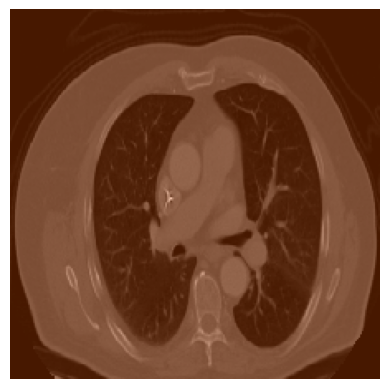

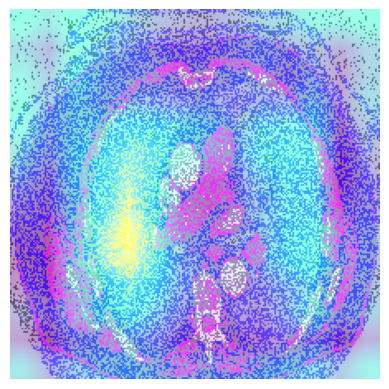

In [65]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import tf_explain

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Choose an index from your test set to visualize
index_to_visualize = 12
img_array = np.expand_dims(X_test[index_to_visualize], axis=0)

# Preprocess the input image
img_array = preprocess_input(img_array)

# Get the prediction for the input image
preds = base_model.predict(img_array)
# Assuming preds is a 2D array where each row corresponds to predictions for a sample
class_index = np.argmax(preds, axis=1)

# Now class_indices contains the predicted class indices for each sample


# Create a GradCAM explainer
explainer = tf_explain.core.GradCAM()
# Specify the layer name directly
last_conv_layer_name = "block5_conv3"
classifier_layer_name = "block5_pool"

# Create a model that includes the VGG16 base model up to the final convolutional layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer(last_conv_layer_name).output)
# Compute GradCAM
grid = explainer.explain(
    validation_data=[img_array, None],
    model=model,
    class_index=None,
    layer_name=last_conv_layer_name
)

# Display the original image
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.show()

# Display GradCAM
plt.imshow(grid, cmap="jet")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 211ms/step


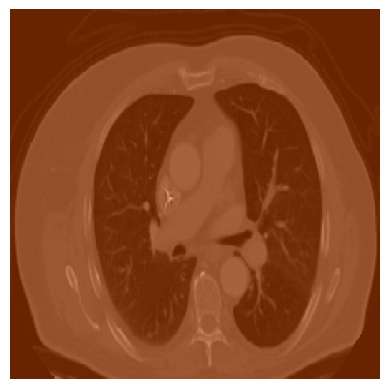

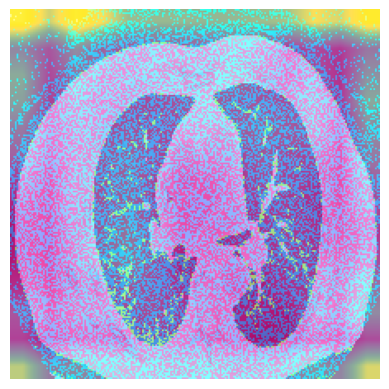

In [69]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import tf_explain

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Choose an index from your test set to visualize
index_to_visualize = 12
img_array = np.expand_dims(X_test[index_to_visualize], axis=0)

# Preprocess the input image
img_array = preprocess_input(img_array)

# Get the prediction for the input image
preds = base_model.predict(img_array)
# Assuming preds is a 2D array where each row corresponds to predictions for a sample
class_index = np.argmax(preds, axis=1)

# Now class_indices contains the predicted class indices for each sample


# Create a GradCAM explainer
explainer = tf_explain.core.GradCAM()
# Specify the layer name directly
last_conv_layer_name = "block5_conv3"
classifier_layer_name = "block5_pool"

# Create a model that includes the VGG16 base model up to the final convolutional layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer(last_conv_layer_name).output)
# Compute GradCAM
grid = explainer.explain(
    validation_data=[img_array, None],
    model=model,
    class_index=0,
    layer_name=last_conv_layer_name
)

# Display the original image
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.show()

# Display GradCAM
plt.imshow(grid, cmap="jet")
plt.axis('off')
plt.show()

In [141]:
# Remove last layer's activation
base_model.layers[-1].activation = None

# Print what the top predicted class is
img_array = np.expand_dims(X_test_preprocessed[1], axis=0)

preds = base_model.predict(img_array)
print('Predicted:', preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

1/1 [==============================] - 0s 193ms/step
Predicted: [[[  0.          0.          0.        ...   0.          0.
     0.       ]
  [  0.          0.          0.        ...   0.          0.
     0.       ]
  [  0.          0.          0.        ...   0.          0.
     0.       ]
  ...
  [  0.          0.          0.        ...   0.         46.111015
     0.       ]
  [  0.          0.          0.        ...   0.          0.
     0.       ]
  [  0.          0.          0.        ...   0.         22.68552
     0.       ]]

 [[  0.          0.          0.        ...   0.          0.
     0.       ]
  [  0.          0.          0.        ...   0.          0.
     0.       ]
  [  0.          0.          0.        ...   0.          0.
     0.       ]
  ...
  [  0.          0.          0.        ...   0.          0.
     0.       ]
  [  0.          0.          0.        ...   0.          0.
     0.       ]
  [  0.          0.          0.        ...   0.        119.43144
     0.   

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [] != values[1].shape = [14,512] [Op:Pack] name: 

In [137]:
np.argmax(preds[0])

382

In [236]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0][0])
        print(preds)
        class_channel = preds[:, pred_index] 

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.reduce_sum(last_conv_layer_output * pooled_grads[..., tf.newaxis], axis=-1)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Debugging: Print shapes
    print(f"last_conv_layer_output shape: {last_conv_layer_output.shape}")
    print(f"pooled_grads shape: {pooled_grads.shape}")
    print(f"Heatmap shape: {heatmap.shape}")

    return heatmap.numpy()


def plot_gradcam(img_arrays, heatmap,image_id, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    heatmap = jet(heatmap)

    heatmap = image.array_to_img(heatmap)
    heatmap = heatmap.resize((img_arrays[image_id].shape[1], img_arrays[image_id].shape[0]))
    heatmap = image.img_to_array(heatmap)

    superimposed_img = heatmap[..., :3] * alpha + img_arrays[image_id]
    superimposed_img = image.array_to_img(superimposed_img)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    plt.suptitle("Cancerous Detection")


    # Plot the original CT scan image in the second subplot
    axes[0].imshow(img_arrays[image_id])
    axes[0].set_title('Original CT Scan')
    axes[0].axis('off')

    axes[1].imshow(superimposed_img)
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')

    plt.tight_layout()

    plt.axis('off')
    plt.show()

# Replace 'conv5_block3_out' with your desired layer name
last_conv_layer_name = 'block5_conv3'

# Generate the heatmap
img_for_heatmap = np.expand_dims(X_test_preprocessed[10], axis=0)  # Add batch dimension
heatmap = make_gradcam_heatmap(img_for_heatmap, base_model, last_conv_layer_name)

# Plot Grad-CAM
plot_gradcam(X_test_preprocessed, heatmap, 10)


tf.Tensor(
[[[[  0.          0.          0.        ...   0.          0.
      0.       ]
   [  0.          0.          0.        ...   0.          0.
      0.       ]
   [  0.          0.          0.        ...   0.          0.
      0.       ]
   ...
   [  0.          0.         26.444176  ...   0.          0.
      0.       ]
   [  0.          0.         11.701223  ...   0.         30.88248
      0.       ]
   [  0.          0.          0.        ...   0.         32.265182
      0.       ]]

  [[  0.          0.          0.        ...   0.          0.
      0.       ]
   [  0.         28.739216    0.        ...   0.          0.
      0.       ]
   [  0.         29.544289   24.366896  ...   0.          0.
      0.       ]
   ...
   [ 14.955233    0.         32.23716   ...   0.          0.
      0.       ]
   [  0.          0.         18.657633  ...   0.          0.
      0.       ]
   [  0.          0.          0.        ...   0.         76.41603
      0.       ]]

  [[  0.          0

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got <tf.Tensor: shape=(512,), dtype=int64, numpy=
array([0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 1,
       5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 3, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 2, 0, 0, 5, 0, 5,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 4, 0, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       1, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 1, 0,
       0, 3, 0, 2, 0, 0, 1, 0, 5, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0,
       0, 5, 0, 0, 0, 2, 0, 3, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 1,
       1, 0, 0, 6, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0,
       0, 6, 0, 0, 3, 0, 0, 0, 4, 6, 0, 0, 0, 6, 0, 0, 0, 3, 0, 0, 5, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 5, 0, 5, 0, 5, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 4, 6, 0, 0, 5, 1, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 6, 1, 0, 0, 0,
       3, 0, 0, 4, 6, 0, 2, 0, 1, 0, 0, 0, 3, 0, 0, 0, 2, 0, 6, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 5, 0, 0, 0, 0, 0, 6, 0, 0, 0,
       0, 0, 0, 0, 6, 0])>

In [209]:
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    x = model.get_layer(last_conv_layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [224]:
import matplotlib.pyplot as cm
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((224,224))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [211]:
heatmap, top_index = make_gradcam_heatmap(X_test_preprocessed, base_model, last_conv_layer_name)

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [] != values[1].shape = [14,512] [Op:Pack] name: 

In [234]:
plt.imshow(img_grad_cam[0])

NameError: name 'img_grad_cam' is not defined

1/1 [==============================] - 0s 314ms/step
[('n04286575', 'spotlight', 0.1496181), ('n03692522', 'loupe', 0.10896716), ('n09229709', 'bubble', 0.104659565), ('n02910353', 'buckle', 0.08396846), ('n03920288', 'Petri_dish', 0.039326616)]


Text(0.5, 1.0, 'Applied Grad-CAM')

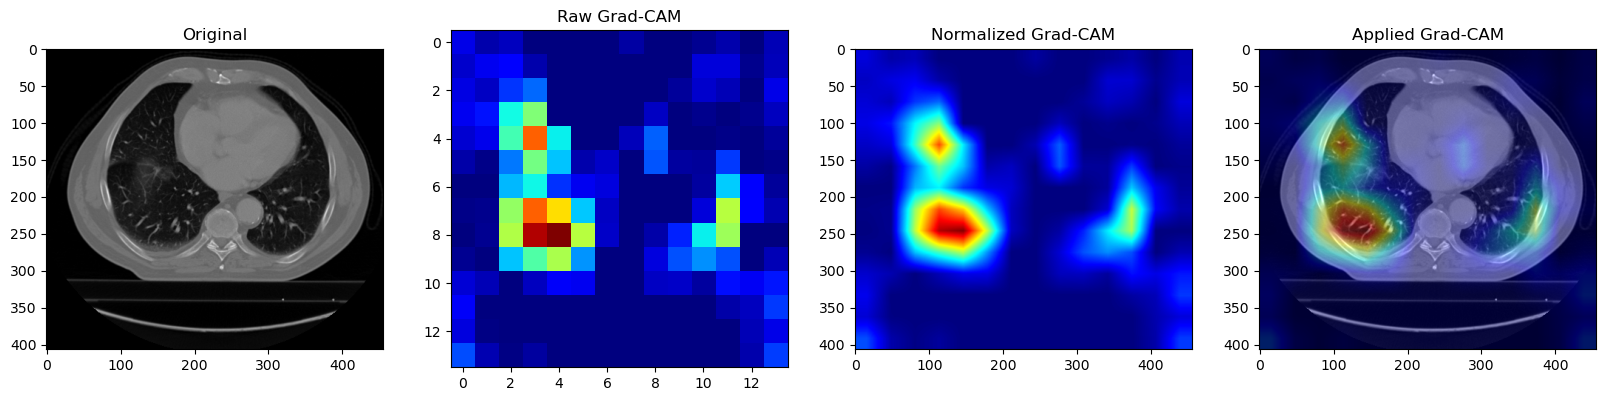

In [23]:
import tensorflow as tf
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
import cv2
import numpy as np

img_bgr = cv2.imread('/Users/levi/Documents/ml_u_imrac/Data/test/adenocarcinoma/000109 (5).png') #source: https://unsplash.com/photos/nKC772R_qog
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_resized = cv2.resize(img_rgb, (224, 224), interpolation = cv2.INTER_CUBIC)

img_tensor = np.expand_dims(img_resized, axis=0) #add batch axis, shape (1,224,224,3)
img_tensor = tf.keras.applications.vgg16.preprocess_input(img_tensor)
predictions = vgg16_model.predict(img_tensor)
print(tf.keras.applications.vgg16.decode_predictions(predictions)[0])
last_conv_layer = vgg16_model.get_layer('block5_conv3') #Output feature map of last convolutional layer in VGG16

heatmap_model = tf.keras.models.Model(inputs=vgg16_model.input,
                                      outputs=[last_conv_layer.output, vgg16_model.output])

with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2)) #Vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature-map channel

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat
import matplotlib.pyplot as plt

squeezed_hm = np.squeeze(heatmap)
normalized_hm = cv2.resize(squeezed_hm, (img_bgr.shape[1], img_bgr.shape[0]))
normalized_hm = (255 * normalized_hm).astype(np.uint8)
normalized_hm = cv2.applyColorMap(normalized_hm, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(normalized_hm, 0.4, img_bgr, 0.9, 0)

rows, cols = 1, 4
fig,axs = plt.subplots(rows, cols, figsize=(20, 20))

axs[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')

axs[1].imshow(squeezed_hm, cmap='jet')
axs[1].set_title('Raw Grad-CAM')

axs[2].imshow(cv2.cvtColor(normalized_hm, cv2.COLOR_BGR2RGB))
axs[2].set_title('Normalized Grad-CAM')

axs[3].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axs[3].set_title('Applied Grad-CAM')

In [27]:
import SimpleITK as sitk
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import tf_explain

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Load the MHD file using SimpleITK
mhd_path = "/Users/levi/Documents/ml_u_imrac/LUNA26/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd"
image_array = sitk.GetArrayFromImage(sitk.ReadImage(mhd_path))
input_tensor = np.expand_dims(np.expand_dims(image_array, axis=0), axis=-1)

# Preprocess the input image based on your specific needs
# Modify this step according to the intensity range of your medical images
# You might not need the preprocess_input function in this case
# img_array = preprocess_input(input_tensor)

# Get the prediction for the input image
preds = base_model.predict(input_tensor)
# Assuming preds is a 2D array where each row corresponds to predictions for a sample
class_index = np.argmax(preds, axis=1)

# Create a GradCAM explainer
explainer = tf_explain.core.GradCAM()
# Specify the layer name directly
last_conv_layer_name = "block5_conv3"

# Create a model that includes the VGG16 base model up to the final convolutional layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer(last_conv_layer_name).output)
# Compute GradCAM
grid = explainer.explain(
    validation_data=[input_tensor, None],
    model=model,
    class_index=class_index,
    layer_name=last_conv_layer_name
)

# Display the original image
plt.imshow(image.array_to_img(input_tensor[0, :, :, 0]))
plt.axis('off')
plt.show()

# Display GradCAM
plt.imshow(grid, cmap="jet")
plt.axis('off')
plt.show()


ValueError: in user code:

    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/levi/anaconda3/envs/Tensorflow/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "vgg16" is incompatible with the layer: expected shape=(None, None, None, 3), found shape=(None, 194, 512, 512, 1)


1/1 [==============================] - 0s 315ms/step
[('n03950228', 'pitcher', 0.3707062), ('n02910353', 'buckle', 0.087444745), ('n07930864', 'cup', 0.07628492), ('n04560804', 'water_jug', 0.054782145), ('n03197337', 'digital_watch', 0.037440248)]


Text(0.5, 1.0, 'Applied Grad-CAM')

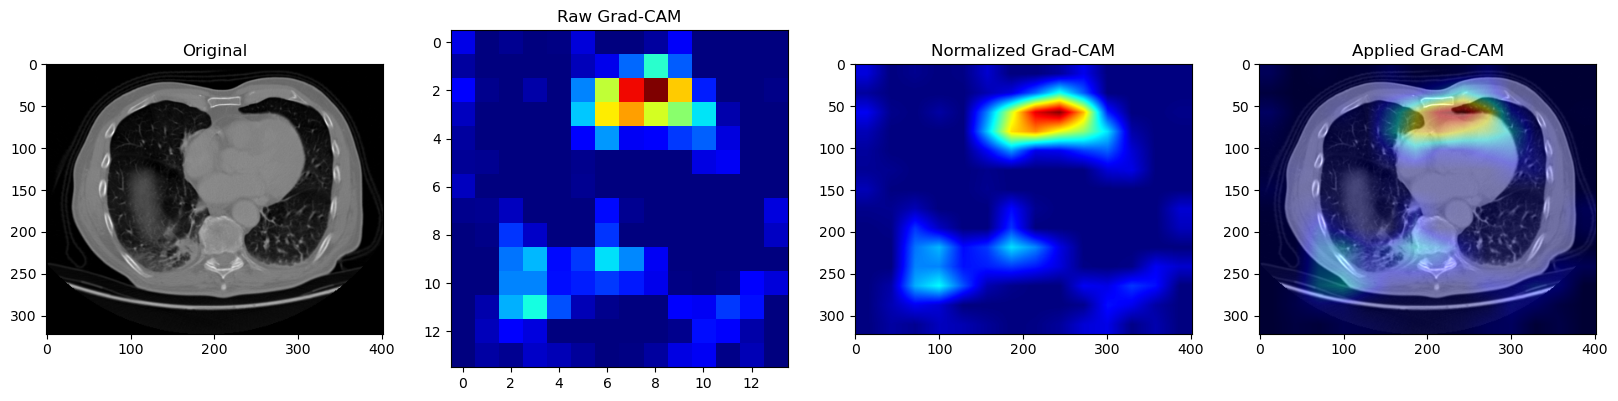

In [45]:
import tensorflow as tf
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
import cv2
import numpy as np

img_bgr = cv2.imread('/Users/levi/Documents/ml_u_imrac/Data/test/large.cell.carcinoma/000114.png') #source: https://unsplash.com/photos/nKC772R_qog
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_resized = cv2.resize(img_rgb, (224, 224), interpolation = cv2.INTER_CUBIC)

img_tensor = np.expand_dims(img_resized, axis=0) #add batch axis, shape (1,224,224,3)
img_tensor = tf.keras.applications.vgg16.preprocess_input(img_tensor)
predictions = vgg16_model.predict(img_tensor)
print(tf.keras.applications.vgg16.decode_predictions(predictions)[0])
last_conv_layer = vgg16_model.get_layer('block5_conv3') #Output feature map of last convolutional layer in VGG16

heatmap_model = tf.keras.models.Model(inputs=vgg16_model.input,
                                      outputs=[last_conv_layer.output, vgg16_model.output])

with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2)) #Vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature-map channel

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat
import matplotlib.pyplot as plt

squeezed_hm = np.squeeze(heatmap)
normalized_hm = cv2.resize(squeezed_hm, (img_bgr.shape[1], img_bgr.shape[0]))
normalized_hm = (255 * normalized_hm).astype(np.uint8)
normalized_hm = cv2.applyColorMap(normalized_hm, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(normalized_hm, 0.4, img_bgr, 0.9, 0)

rows, cols = 1, 4
fig,axs = plt.subplots(rows, cols, figsize=(20, 20))

axs[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')

axs[1].imshow(squeezed_hm, cmap='jet')
axs[1].set_title('Raw Grad-CAM')

axs[2].imshow(cv2.cvtColor(normalized_hm, cv2.COLOR_BGR2RGB))
axs[2].set_title('Normalized Grad-CAM')

axs[3].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axs[3].set_title('Applied Grad-CAM')

In [71]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained VGG16 model
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

# Load and preprocess the input image
img_bgr = cv2.imread('/Users/levi/Documents/ml_u_imrac/Data/test/large.cell.carcinoma/000114.png')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary mask for region filling
_, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Perform region filling
filled_mask = binary_mask.copy()
cv2.floodFill(filled_mask, None, (0, 0), 255)

# Invert the filled mask to get the region of interest (ROI)
roi = cv2.bitwise_not(filled_mask)

# Remove the background using the ROI
img_without_bg = cv2.bitwise_and(img_bgr, img_bgr, mask=roi)

# Resize the image for VGG16 input size
img_resized = cv2.resize(img_without_bg, (224, 224), interpolation=cv2.INTER_CUBIC)
img_tensor = np.expand_dims(img_resized, axis=0)
img_tensor = tf.keras.applications.vgg16.preprocess_input(img_tensor)

# Get the output of the last convolutional layer and the predictions
last_conv_layer = vgg16_model.get_layer('block5_conv3')
heatmap_model = tf.keras.models.Model(inputs=vgg16_model.input, outputs=[last_conv_layer.output, vgg16_model.output])

# Calculate gradients and generate Grad-CAM
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

# Resize the heatmap to match the original image size
squeezed_hm = np.squeeze(heatmap)
normalized_hm = cv2.resize(squeezed_hm, (img_without_bg.shape[1], img_without_bg.shape[0]))

# Rotate the normalized heatmap 90 degrees clockwise
rotated_normalized_hm = cv2.rotate(normalized_hm, cv2.ROTATE_90_CLOCKWISE)

# Resize the rotated normalized heatmap to match the original image size
resized_rotated_normalized_hm = cv2.resize(rotated_normalized_hm, (224,224))

# Superimpose the resized rotated normalized_hm on the original image
superimposed_img = cv2.addWeighted(img_bgr, 0.9, cv2.cvtColor(resized_rotated_normalized_hm, cv2.COLOR_GRAY2BGR), 0.4, 0)

# Display the results
rows, cols = 1, 4
fig, axs = plt.subplots(rows, cols, figsize=(20, 20))

axs[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')

axs[1].imshow(cv2.cvtColor(img_without_bg, cv2.COLOR_BGR2RGB))
axs[1].set_title('Image without Background')

axs[2].imshow(resized_rotated_normalized_hm, cmap='jet')
axs[2].set_title('Resized Rotated Normalized Grad-CAM')

axs[3].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axs[3].set_title('Superimposed Image')

plt.show()


error: OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/core/src/arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'
